# The Perceptron Algorithm

This Jupyter Notebook is dedicated to understanding and implementing the perceptron algorithm on soccer data. You can find the dataset [2022-2023 Soccer Player Stats Dataset](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?resource=download).

The following packages are required to run the attached code:

- [Plotly](https://plotly.com/python/)

- [Pandas](https://pandas.pydata.org/docs/)

- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)

- [Numpy](https://numpy.org/doc/)

- [Seaborn](https://seaborn.pydata.org/)

- [SciKit Learn](https://scikit-learn.org/stable/)

## Perceptron Explained:

***
The perceptron is a basic building block of artificial intelligence that mimics how a single neuron in the brain works. It takes multiple inputs, each with its own importance (weights), combines them with a bias term, and produces an output. By adjusting the weights and bias based on examples, the perceptron can learn to make decisions or predictions, such as recognizing patterns in data or distinguishing between different classes of objects.

You can see the structure here:

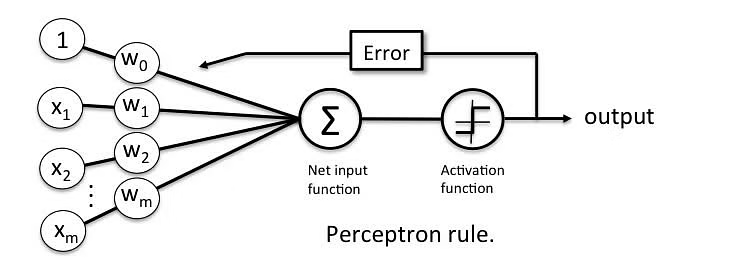

As you can see, there is a single "neuron" that has a bias term (represented by the 1) and data terms that are all weighted. There is then an activation function (normally the step function for perceptron) before retraining the model from the error of the first iteration, which is often called an "epoch."

Image from [SimpliLearn](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron).

***

## Description of the Algorithm:

***
The perceptron algorithm is a fundamental supervised learning algorithm for binary classification tasks. Although the algorithm is simple, it's very effective and an essential part of unsupervised machine learning.

Here is an example of binary classification (specifcally logistic regression, which we will discuss later!):

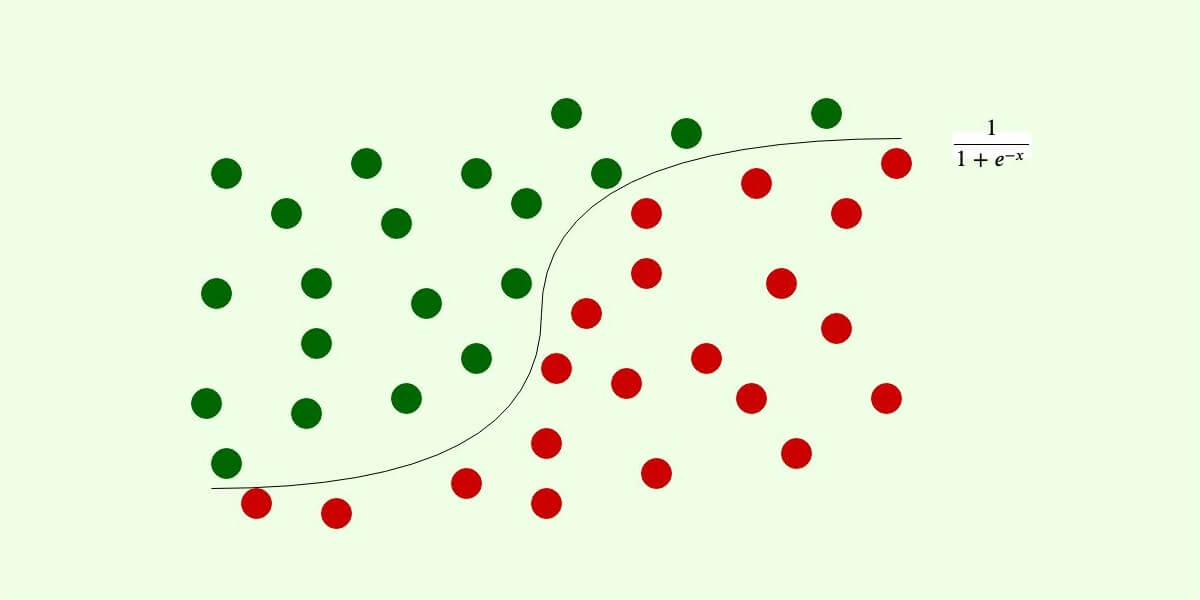

With two classes of data, our goal is to successfully predict which data points belong to each class. 

**Steps:**

1. Initialize Weights and Bias: Start by initializing the weights \( w \) and bias \( b \) to small random values or zeros.

2. Input Features: For each training example \( (x_1, x_2, ..., x_n) \), where \( n \) is the number of features, and its corresponding target label \( y \), do the following:

3. Calculate Linear Combination: Compute the linear combination of the input features and weights, $ z = \sum_{i=1}^{n} w_i \cdot x_i + b $.

4. Activation Function: Apply an activation function (usually a step function) to the linear combination to obtain the predicted class label:

   $
   \hat{y} = \begin{cases}
   1 & \text{if } z \geq 0 \\
   0 & \text{otherwise}
   \end{cases}
   $

5. Update Weights: Update the weights and bias based on the prediction error:
   $
   w_i = w_i + \alpha \cdot (y - \hat{y}) \cdot x_i
   $
   $
   b = b + \alpha \cdot (y - \hat{y})
   $
   where $\alpha$ is the learning rate, a hyperparameter controlling the size of the weight updates.

6. Repeat: Iterate through the training examples for multiple epochs, adjusting the weights and bias after each pass through the dataset.

7. Convergence: The algorithm stops when either all examples are classified correctly or a maximum number of epochs is reached.

The perceptron algorithm is effective for linearly separable datasets but may not converge if the data is not linearly separable.

Image from [AI Geek Programmer](https://manduk.ai/tag/logistic-regression/).
***

## Setting Up:

***
Import the necessary modules and the data.
***

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import math

#Import the dataset. 
soccer = pd.read_csv("/Users/pstern/Desktop/INDE-577/Datasets/soccer_stats.csv", encoding='ISO-8859-1', delimiter=';')

***
We only want players who have played a reasonable number of games. Let's only choose players who have played 10 games worth of time. 
***

In [33]:
# Filter the data such that we are only including players who have player more than 10 games worth of time.
soccer = soccer[soccer['90s'] >= 10.0]

***
For our binary classification, let's compare attackers and defenders.

***

In [34]:
# Filter to only include forwards and defenders.
data = soccer[(soccer['Pos'] == 'FW') | (soccer['Pos'] == 'DF')]

# Get the forwards and defenders.
forward = data[data['Pos'] == 'FW']
defender = data[data['Pos'] == 'DF']

***
For our predictors let's look at goals and clearances. 
***

In [35]:
# Get the goals for forwards and defenders to use as a predictor.
fw_goals = forward['Goals'].values
df_goals = defender['Goals'].values

# Select clearances as a predictor.
fw_clr = forward['Clr'].values
df_clr = defender['Clr'].values

# Get the data for our model
predictors = data[['Goals', 'Clr']].values
response = [int(val) for val in (data['Pos'] == 'FW')]
response = np.array(response)

***
Finally, let's get testing and training data, so we can check our results on new data.
***

In [36]:
# Split the data into training and testing sets.
train_p, test_p, train_r, test_r = train_test_split(predictors, response, test_size = 0.4, random_state = 42)

***
Let's plot our data to see what we're working with.
***

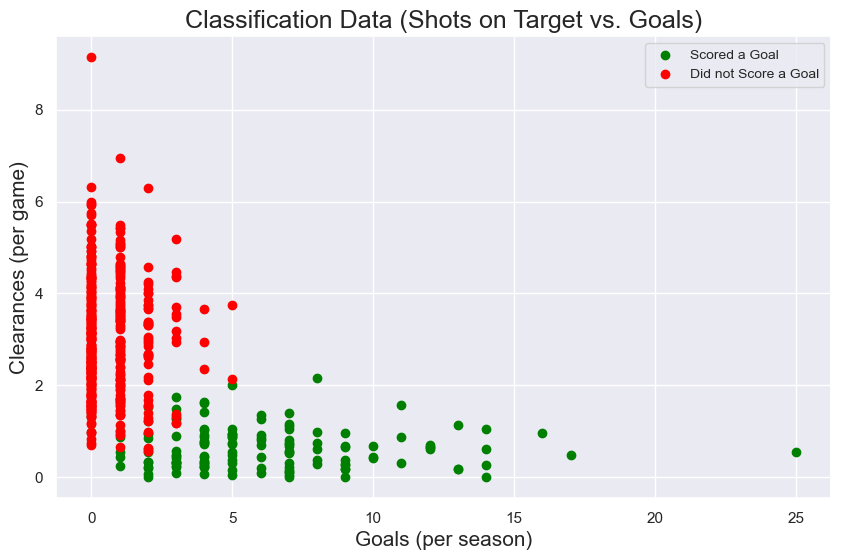

In [37]:
# Set the theme. 
sns.set_theme()

plt.figure(figsize = (10, 6))

# Add the red card players to the plot.
plt.scatter(fw_goals, fw_clr, color = "green", label = "Scored a Goal")

# Add the non red card players to the plot.
plt.scatter(df_goals, df_clr, color = "red", label = "Did not Score a Goal")
plt.xlabel("Goals (per season)", fontsize = 15)
plt.ylabel("Clearances (per game)", fontsize = 15)
plt.legend(fontsize = 10, loc = "upper right")
plt.title("Classification Data (Shots on Target vs. Goals)", fontsize = 18)
plt.show()

Outside of some overlap near (0,0), it seems like we have two clear "classes". I'm excited to see how the model does. 

## Implementing the Algorithm:

***
Implement a perceptron class that, for each epoch, makes predictions and calculates the number of errors.
***

In [38]:
# A class that represents a single perceptron neuron. 
class Perceptron(object):
    '''
    Class Attributes:

    eta : float
        The learning rate used in training the perceptron.

    epochs : int
        The number of epochs for training the perceptron.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry represents the bias.

    errors_: list
        A list containing the number of misclassifications after each epoch of training.
    '''
    # Initialize Perceptron object.
    def __init__(self, eta = .5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        '''
        Trains the perceptron using the provided feature vectors X and associated labels y.
        '''
        # Initialize random weights.
        self.weight = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        
        # Iterate through the epochs.
        for _ in range(self.epochs):
            errors = 0

            # Iterate through each sample in the training set.
            for xi, target in zip(X, y):

                # Update weights based on the difference between predicted and actual class.
                update = self.eta * (self.predict(xi) - target)
                self.weight[:-1] -= update * xi
                self.weight[-1] -= update

                #Keep track of the number of errors.
                errors += int(update != 0)

            # If there are no errors in this epoch, return.
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        '''
        A helper function that calculates the net input for a given feature vector X.
        '''
        # Calculate net input (sum of weighted inputs plus bias).
        return np.dot(X, self.weight[:-1]) + self.weight[-1]
    
    def predict(self, X):
        '''
        Predicts the class labels for the input feature vectors X after training.
        '''
        # Predict class labels based on net input.
        return np.where(self.net_input(X) >= 0.0, 1, 0)


## Applying the Algorithm:

***
Create an instance of the class to train the model.
***

In [39]:
# Instantiate an instance of the Perceptron class.
ptron = Perceptron(epochs = 1000)

# Train the model.
ptron.train(train_p, train_r)

***
Make predictions on the training data.
***

In [40]:
# Predict make predictions based on training.
y_hat = ptron.predict(train_p).reshape(-1,1)

# Compare y_hat and y
errors = 0
for i in range(len(y_hat)):
    if y_hat[i] == train_r[i]:
        errors += 1
error_percent = errors / len(y_hat)

print(f"We get an error_percent of {round(error_percent * 100, 2)}.")

We get an error_percent of 95.95.


***
Analyze the data.
***

The perceptron model made the correct prediction about 96 of the time. This does very, very well! The model seems to really be able to capture the true spread of the data.

***
Plot decision regions created by the model. 
***

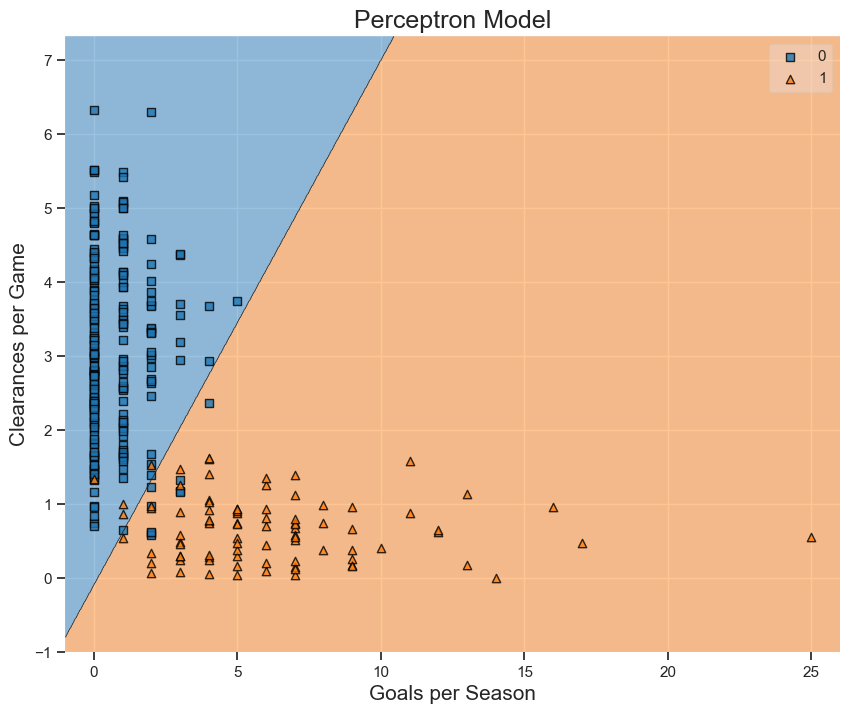

In [42]:
# Set the figure size. 
plt.figure(figsize = (10, 8))

# Print the decision regions. 
plot_decision_regions(train_p, train_r, clf = ptron)

# Plot the titles and labels. 
plt.title("Perceptron Model", fontsize = 18)
plt.xlabel("Goals per Season", fontsize = 15)
plt.ylabel("Clearances per Game", fontsize = 15)
plt.show()

As we can see, the decision regions seem to do a really good job of capturing the data, even though there are a few cases in the overlapping area that gets a few predictions wrong.

***
Let's look at the errors at each iteration.
***

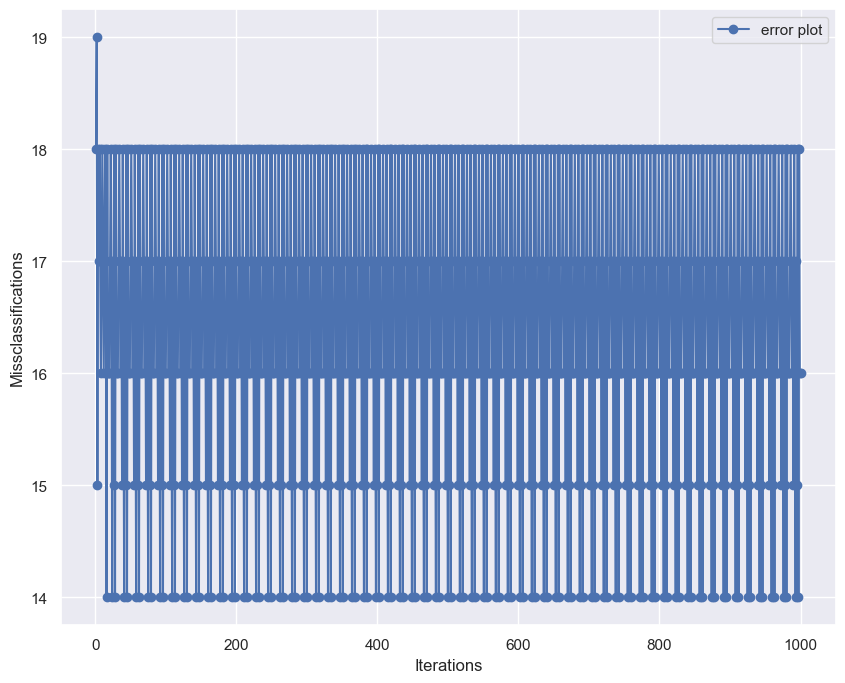

In [57]:
# Set the figure size. 
plt.figure(figsize = (10, 8))

# Plot the errors.
plt.plot(range(1, len(ptron.errors_)+1), ptron.errors_,  marker = "o", label = "error plot")

# Set the axis titles and legend.
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.legend()
plt.show()

As we can see, the number of errors goes down quickly at the start, but doesn't seem to improve after the intial few epochs. This helps us know if we have a good number of epochs or not. 

***
Let's see how a model with 50 epochs compares.
***

In [61]:
# Instantiate an instance of the Perceptron class.
new_ptron = Perceptron(epochs = 50)

# Train the model.
new_ptron.train(train_p, train_r)

***
Again, let's get the error. 
***

In [62]:
# Predict make predictions based on training.
y_hat = new_ptron.predict(train_p).reshape(-1,1)

# Compare y_hat and y
errors = 0
for i in range(len(y_hat)):
    if y_hat[i] == train_r[i]:
        errors += 1
error_percent = errors / len(y_hat)

print(f"Now we get an error_percent of {round(error_percent * 100, 2)}.")

Now we get an error_percent of 94.39.


We get something that has slightly more error, but it still does very very well. We have to decide if it is worth the long runtime for this marginal improvement, or should we decide on something between 50 and 1000?

***
Now, let's see how perceptron does with new data. Is it overfit to the test data?
***

In [63]:
# Predict make predictions based on training, now with new data.
y_hat = ptron.predict(test_p).reshape(-1,1)

# Compare y_hat and y
errors = 0
for i in range(len(y_hat)):
    if y_hat[i] == test_r[i]:
        errors += 1
error_percent = errors / len(y_hat)

print(f"We get an error_percent of {round(error_percent * 100, 2)}.")

We get an error_percent of 96.74.


No! The model does not seem overfit to the training data. In fact, the model did even better on the test data as compared to the training data. 

***
Does it perform equally well for the model that was trained with fewer epochs.
***

In [64]:
# Predict make predictions based on training, now with new data.
y_hat = new_ptron.predict(test_p).reshape(-1,1)

# Compare y_hat and y
errors = 0
for i in range(len(y_hat)):
    if y_hat[i] == test_r[i]:
        errors += 1
error_percent = errors / len(y_hat)

print(f"We get an error_percent of {round(error_percent * 100, 2)}.")

We get an error_percent of 95.81.


Again, it continues to do well, still scoring just slightly less than the model trained on 1,000 epochs. 

## Conclusions:

***
In this notebook, we implemented and applied the perceptron algorithm for binary classification tasks. We used a dataset of soccer player statistics to predict whether a player is an attacker or a defender based on their goals and clearances.

Here are some takeaways for the perceptron algorithm:

- Simplicity and Efficiency: The perceptron algorithm is a simple and efficient algorithm for binary classification tasks. It iteratively updates the model parameters based on misclassified instances until convergence, making it computationally efficient for large datasets.

- Linear Separability: The perceptron algorithm works well when the classes are linearly separable. It can converge to a solution that perfectly separates the classes if such a hyperplane exists. However, if the classes are not linearly separable, the algorithm may not converge, or it may converge to a suboptimal solution.

The perceptron algorithm did great! I am excited to see if future algorithms can do better and I'm interested to see how we tackle non-linear classification problems.
***